Korenaga 2011
======

Temperature dependent convection
----

This Notebooks implements the case of two-dimensional, incompressible, internally-heated fmantle convection.


**Keywords:** Stokes system, advective diffusive systems, analysis tools, tools for post analysis, rheologies


**References**

Korenaga, Jun. "Scaling of plate tectonic convection with pseudoplastic rheology." Journal of Geophysical Research: Solid Earth 115.B11 (2010).
http://onlinelibrary.wiley.com/doi/10.1029/2010JB007670/full

In [1]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

import os
import sys
import glob
import natsort
import shutil
from easydict import EasyDict as edict
import operator
import pint
import time
import operator
from slippy2 import boundary_layer2d
from slippy2 import material_graph
from slippy2 import spmesh

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [2]:
#####
#Stubborn version number conflicts - need to figure out my Docker container runs an old version. For now...
#####
try:
    natsort.natsort = natsort.natsorted
except:
    natsort.natsort = natsort.natsort

Model name and directories
-----

In [3]:
############
#Model letter and number
############


#Model letter identifier default
Model = "Z"

#Model number identifier default:
ModNum = 0

#Any isolated letter / integer command line args are interpreted as Model/ModelNum

if len(sys.argv) == 1:
    ModNum = ModNum 
elif sys.argv[1] == '-f': #
    ModNum = ModNum 
else:
    for farg in sys.argv[1:]:
        if not '=' in farg: #then Assume it's a not a paramter argument
            try:
                ModNum = int(farg) #try to convert everingthing to a float, else remains string
            except ValueError:
                Model  = farg

In [4]:
###########
#Standard output directory setup
###########

outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" 
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)


In [5]:
###########
#you can hard code a different checkpoint Load path here, 
###########

checkpointLoadPath = checkpointPath
#checkpointLoadPath = 'results/Z/6/checkpoint/'

        
comm.Barrier() #Barrier here so no procs run the check in the next cell too early

In [6]:
###########
#Check if starting from checkpoint
###########

checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointLoadPath):
    if files:
        #print dirpath, 'has files'
        if checkpointPath != checkpointLoadPath:
            print("You're loading checkpoints from somewhere other than *outputPath* ...careful")
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        #print dirpath, 'is empty'
        checkpointLoad = False
        
comm.Barrier()

In [7]:
print(checkpointLoad)

False


In [8]:
# setup summary output file (name above)
if checkpointLoad:
    checkpointLoadDir = natsort.natsort(checkdirs)[-1] #Get the most recent checkpoint directory
    fuzzyFile = glob.glob(os.path.join(checkpointLoadDir, '*.dat'))[0]
    if uw.rank() == 0:
        shutil.copyfile(fuzzyFile, outputPath+outputFile)
    comm.Barrier()
    f_o = open(os.path.join(outputPath, outputFile), 'a')
    prevdata = np.genfromtxt(os.path.join(outputPath, outputFile), skip_header=0, skip_footer=0)
    if len(prevdata.shape) == 1: #this is in case there is only one line in previous file
        realtime = prevdata[-1]  #This corresponds to the column you write time data to
    else:
        realtime = prevdata[prevdata.shape[0]-1, -1]
    step = int(checkpointLoadDir.split('/')[-1])
    timevals = [0.]
else:
    f_o = open(outputPath+outputFile, 'w')
    realtime = 0.
    step = 0
    timevals = [0.]

Setup parameters
-----

Set simulation parameters for test.

**Use pint to setup any unit conversions we'll need**

In [9]:
u = pint.UnitRegistry()
cmpery = 1.*u.cm/u.year
mpermy = 1.*u.m/u.megayear
year = 1.*u.year
spery = year.to(u.sec)
cmpery.to(mpermy)

/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:672: DeprecationWarning: PlainTextFormat

<Quantity(10000.0, 'meter / megayear')>

In [10]:
#box_half_width =4000e3
#age_at_trench = 100e6
#cmperyear = box_half_width / age_at_trench #m/y
#mpersec = cmperyear*(cmpery.to(u.m/u.second)).magnitude #m/sec
#print(cmperyear, mpersec )

**Set parameter dictionaries**

In [11]:
###########
#Parameter / settings dictionaries get saved&loaded using pickle
###########
 
dp = edict({}) #dimensional parameters
sf = edict({}) #scaling factors
ndp = edict({}) #dimensionless paramters
md = edict({}) #model paramters, flags etc
#od = edict({}) #output frequencies


In [12]:
dict_list = [dp, sf, ndp, md]
dict_names = ['dp.pkl', 'sf.pkl', 'ndp.pkl', 'md.pkl']

def save_pickles(dict_list, dict_names, dictPath):
    import pickle
    counter = 0
    for pdict in dict_list:
        myfile = os.path.join(dictPath, dict_names[counter])
        with open(myfile, 'wb') as f:
            pickle.dump(pdict, f)
        counter+=1


#ended up having to pretty much write a hard-coded function
#All dictionaries we want checkpointed will have to  be added here 
#and where the function is called
#Fortunately, this function is only called ONCE

def load_pickles():
    import pickle
    dirpath = os.path.join(checkpointLoadPath, str(step))
    dpfile = open(os.path.join(dirpath, 'dp.pkl'), 'r')
    dp = pickle.load(dpfile)
#    #
    ndpfile = open(os.path.join(dirpath, 'ndp.pkl'), 'r')
    ndp = edict(pickle.load(ndpfile))
    #
    sffile = open(os.path.join(dirpath, 'sf.pkl'), 'r')
    sf = edict(pickle.load(sffile))
    #
    mdfile = open(os.path.join(dirpath, 'md.pkl'), 'r')
    md = edict(pickle.load(mdfile))
    return dp, ndp, sf, md

In [13]:
#dimensional parameter dictionary
dp = edict({'LS':2900.*1e3,
           'rho':3300,
           'g':9.8, 
           #'eta0':5e20,
           #'eta0':1e21,    #This will give Ra ~ 2e7, closer to models by Van Hunen, Billen etc.
           'eta0': 2.05e22, #This will give Ra = 1e6 as quoted on Korenaga's paper
           'k':1e-6,
           'a':2e-5,
           'c':1200., # Heat capacity J kg−1 K-1 
           'deltaT':1300, 
           'TS':273.,
           'cohesion':1e4, #i.e totally negligable...
           'fc':0.015,
            #'fc':0.03,
           'E':162123.00, #with this choice, ndp.E = 15.
           'V':3.457e-07, ## 1e-10, can be considered negligible, 3.457e-07 gives ndp.W of 3.
           'R':8.314,
           'StALS':100e3,
           'subzone':0.0,   #X position of subduction zone...km
           'orientation':30.,
           'faultDepth':250e3,
            'w0':145e3,
            'H':3.709e-12 #Internal heating W kg-1, gives ndp.H = 20.
           })

dp.etaFault = dp.eta0*0.01 #this will be the fault (linear) viscosity value in either the isotropic or TI case
dp.TI = dp.TS + dp.deltaT


#scale_factors




In [31]:
#Modelling and Physics switches

md = edict({'refineMesh':True,
            'stickyAir':False,
            'subductionFault':False,
            'symmetricIcs':False,
            'velBcs':False,
            'aspectRatio':4,
            'compBuoyancy':False, #use compositional & phase buoyancy, or simply thermal
            'periodicBcs':True,
            'melt_viscosity_reduction':False,
            'lower_mantle':False,
            'faultType':'None', #or 'Trans', Iso', or None
            'RES':128,
            'loadRES':64,
            #'elementType':"Q1/dQ0"
            'elementType':"Q2/DPC1",
            'loadTemp':True, #a flag to load a specific temp file
            'courantFac':0.5,
             'ppc':50
            })

In [15]:
###########
#If starting from a checkpoint load params from file
###########

if checkpointLoad:
    dp, ndp, sf, md = load_pickles()  #remember to add any extra dictionaries

In [16]:
###########
#If command line args are given, overwrite
#Note that this assumes that params as commans line args/
#only append to the 'dimensional' and 'model' dictionary (not the non-dimensional)
###########    


###########
#If extra arguments are provided to the script" eg:
### >>> uw.py 2 dp.arg1=1 dp.arg2=foo dp.arg3=3.0
###
###This would assign ModNum = 2, all other values go into the dp dictionary, under key names provided
###
###Two operators are searched for, = & *=
###
###If =, parameter is re-assigned to givn value
###If *=, parameter is multipled by given value
###
### >>> uw.py 2 dp.arg1=1 dp.arg2=foo dp.arg3*=3.0
###########

for farg in sys.argv[1:]:
    try:
        (dicitem,val) = farg.split("=") #Split on equals operator
        (dic,arg) = dicitem.split(".") #colon notation
        if '*=' in farg:
            (dicitem,val) = farg.split("*=") #If in-place multiplication, split on '*='
            (dic,arg) = dicitem.split(".")
            
        if val == 'True': 
            val = True
        elif val == 'False':     #First check if args are boolean
            val = False
        else:
            try:
                val = float(val) #next try to convert  to a float,
            except ValueError:
                pass             #otherwise leave as string
        #Update the dictionary
        if farg.startswith('dp'):
            if '*=' in farg:
                dp[arg] = dp[arg]*val #multiply parameter by given factor
            else:
                dp[arg] = val    #or reassign parameter by given value
        if farg.startswith('md'):
            if '*=' in farg:
                md[arg] = md[arg]*val #multiply parameter by given factor
            else:
                md[arg] = val    #or reassign parameter by given value
                
    except:
        pass
            

comm.barrier()

In [17]:
if not checkpointLoad:
    sf = edict({'stress':dp.LS**2/(dp.k*dp.eta0),
                'lith_grad':dp.rho*dp.g*(dp.LS)**3/(dp.eta0*dp.k) ,
                 'vel':dp.LS/dp.k,
                 'SR':dp.LS**2/dp.k,
                 'W':(dp.rho*dp.g*dp.LS)/(dp.R*dp.deltaT), #This is the activation energy scale, in terms of depth (not pressure)
                 'E': 1./(dp.R*dp.deltaT), #To scale E, V, we used a guesstimated adiabatic deltaT
                 'H':(dp.LS)**2/(dp.c*dp.deltaT*dp.k)

               }) 

    
    #dimensionless parameters


    ndp = edict({'RA':(dp.g*dp.rho*dp.a*dp.deltaT*(dp.LS)**3)/(dp.k*dp.eta0),
                'cohesion':dp.cohesion*sf.stress,
                'fcd':dp.fc*sf.lith_grad,
                'gamma':dp.fc/(dp.a*dp.deltaT),
                'E':dp.E*sf.E,
                'W':dp.V*sf.W,
                'TSP':0., 
                'TIP':1.,
                'n':1.,
                'TS':dp.TS/dp.deltaT,
                'TI':dp.TI/dp.deltaT,
                'eta_min':1e-3,
                'eta_max':1e5,
                'H':20.,
                'Tmvp':0.6,
                'Steta0':1e2,
                'subzone':dp.subzone/dp.LS,   #X position of subduction zone..
                'orientation':dp.orientation,
                'faultDepth':dp.faultDepth/dp.LS,
                 'etaFault':dp.etaFault/dp.eta0,
                 'w0':dp.w0/dp.LS,
                 'H':dp.H*sf.H
                })



    #ndp.RA = 1e6 #this is what Korenaga sets it to

#Some final derived values go into the Dictionaries
dp.VR = (0.1*(dp.k/dp.LS)*ndp.RA**(2/3.)) #characteristic velocity
dp.SR = dp.VR/dp.LS #characteristic strain rate
ndp.VR = dp.VR*sf.vel #characteristic velocity
ndp.SR = dp.SR*sf.SR #characteristic strain rate
ndp.StRA = (3300.*dp.g*(dp.LS)**3)/(dp.eta0 *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force


**Model setup parameters**

In [18]:
#md.RES = 128

In [19]:
###########
#Model setup parameters
###########




MINX = -0.5*(md.aspectRatio)
MAXX = 0.5*(md.aspectRatio)
MINY = 0.
MAXY = 1.

    
    
dim = 2          # number of spatial dimensions


#MESH STUFF

Xres = int(md.RES*md.aspectRatio*2)


if md.stickyAir:
    Yres = int(md.RES)
    MAXY = 1. + dp.StALS/dp.LS #150km
    
else:
    Yres = int(md.RES)
    MAXY = 1.


periodic = [False, False]
if md.periodicBcs:
    periodic = [True, False]



#System/Solver stuff

PIC_integration=True
ppc = 25

#Output and safety stuff



#Metric output stuff
figures =  'gldb' #glucifer Store won't work on all machines, if not, set to 'gldb' 
swarm_repop, swarm_update = 1e6, 20
gldbs_output = 5
checkpoint_every, files_output = 100, 100
metric_output = 10
sticky_air_temp = 1e6

Create mesh and finite element variables
------

In [20]:


mesh = uw.mesh.FeMesh_Cartesian( elementType = (md.elementType),
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX, MINY), 
                                 maxCoord    = (MAXX, MAXY), periodic=periodic)

velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

# Initialise values
velocityField.data[:]       = [0.,0.]
pressureField.data[:]       = 0.
temperatureDotField.data[:] = 0.

In [21]:
coordinate = fn.input()
depthFn = MAXY - coordinate[1] #a function providing the depth


xFn = coordinate[0]  #a function providing the x-coordinate
yFn = coordinate[1]

## Mesh refinement

In [22]:
mesh.reset()

jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
yFn = coordinate[1]
yField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
yField.data[:] = 0.
yBC = uw.conditions.DirichletCondition( variable=yField, indexSetsPerDof=(jWalls,) )

# set bottom wall temperature bc
for index in mesh.specialSets["MinJ_VertexSet"]:
    yField.data[index] = mesh.minCoord[1]
# set top wall temperature bc
for index in mesh.specialSets["MaxJ_VertexSet"]:
    yField.data[index] = mesh.maxCoord[1]
    
    
    
s = 2.
intensityFac = 5.
intensityFn = MINY + (MAXY-MINY)*(((yFn - MINY)/(MAXY-MINY))**s)
intensityFn *= intensityFac
intensityFn += 1.


yLaplaceEquation = uw.systems.SteadyStateHeat(temperatureField=yField, fn_diffusivity=intensityFn, conditions=[yBC,])

# get the default heat equation solver
yLaplaceSolver = uw.systems.Solver(yLaplaceEquation)
# solve
yLaplaceSolver.solve()


#Get the array of Y positions - copy may be necessary, not sure. 
newYpos = yField.data.copy() 

uw.barrier()
with mesh.deform_mesh():
     mesh.data[:,1] = newYpos[:,0]


In [23]:
fig= glucifer.Figure()
#fig.append( glucifer.objects.Surface(mesh, yField))
fig.append(glucifer.objects.Mesh(mesh))
#fig.append( glucifer.objects.Points(swarm, temperatureField))
#fig.show()
#fig.save_database('test.gldb')

Initial conditions
-------


In [24]:
#Sinusoidal initial condition
A = 0.2
sinFn = depthFn + A*(fn.math.cos( math.pi * coordinate[0])  * fn.math.sin( math.pi * coordinate[1] ))        
    
#Boundary layer/slab initial condition
#w0 = 0.1


delX = -1.*fn.math.abs((coordinate[0]/MINX))   + 1.
w = ndp.w0*fn.math.sqrt(delX + 1e-10)
tempBL = (ndp.TIP - ndp.TSP) *fn.math.erf((depthFn)/w) + ndp.TSP
#
                   
tempSlab = (ndp.TIP - ndp.TSP) *fn.math.erf((fn.math.abs(xFn)*2.)/ndp.w0) + ndp.TSP       

tempFn1 =  fn.misc.min(tempBL, tempSlab)
                   
blFn = fn.branching.conditional([(coordinate[1] > 0.25, tempFn1), 
                                    (True, 1.)])


tempFn = blFn #partition the temp between these two fuctions
#tempFn = sinFn #partition the temp between these two fuctions

In [25]:
if not checkpointLoad:
    temperatureField.data[:] = tempFn.evaluate(mesh)  

In [26]:
np.random.seed(20)#set seed for reproducibility
temperatureField.data[:,0] += (np.random.rand(mesh.data.shape[0]) -  0.5)*1e-2

In [27]:
#Make sure material in stick air region is at the surface temperature.
for index, coord in enumerate(mesh.data):
            if coord[1] >= 1.:
                temperatureField.data[index] = ndp.TSP

In [52]:
mesh.elementRes, mesh.elementType

((1024, 128), 'Q2')

In [55]:
#instead of checkpoint loading, do this


if (md.loadTemp ==True) and (md.RES==128):
    temperatureField.load(os.path.join("temperature128.h5"))


#This whole bit can read in and resave a field at a different resolution

###Hardcode the subduction zone location, for some reason this isn't going in the dict
ndp.subzone=0.375
       
loadXres = int(md.loadRES*md.aspectRatio*2)

loadYres = int(md.loadRES)
    

    
meshSaved = uw.mesh.FeMesh_Cartesian(  elementType = (md.elementType),
                                 elementRes  = (loadXres, loadYres), 
                                 minCoord    = (MINX, MINY), 
                                 maxCoord    = (MAXX, MAXY), periodic=[False,False], partitioned=True)
    
    
    
temperatureFieldSaved    = uw.mesh.MeshVariable( mesh=meshSaved,         nodeDofCount=1 )
#temperatureDotFieldSaved = uw.mesh.MeshVariable( mesh=meshSaved,         nodeDofCount=1 )
#pressureFieldSaved       = uw.mesh.MeshVariable( mesh=meshSaved.subMesh, nodeDofCount=1 )
#velocityFieldSaved       = uw.mesh.MeshVariable( mesh=meshSaved,         nodeDofCount=2 )


savedjWalls = meshSaved.specialSets["MinJ_VertexSet"] + meshSaved.specialSets["MaxJ_VertexSet"]
yFn = coordinate[1]
yField = uw.mesh.MeshVariable( mesh=meshSaved, nodeDofCount=1 )
yField.data[:] = 0.
yBC = uw.conditions.DirichletCondition( variable=yField, indexSetsPerDof=(savedjWalls,) )

# set bottom wall temperature bc
for index in meshSaved.specialSets["MinJ_VertexSet"]:
    yField.data[index] = meshSaved.minCoord[1]
# set top wall temperature bc
for index in meshSaved.specialSets["MaxJ_VertexSet"]:
    yField.data[index] = meshSaved.maxCoord[1]



s = 2.
intensityFac = 5.
intensityFn = MINY + (MAXY-MINY)*(((yFn - MINY)/(MAXY-MINY))**s)
intensityFn *= intensityFac
intensityFn += 1.


yLaplaceEquation = uw.systems.SteadyStateHeat(temperatureField=yField, fn_diffusivity=intensityFn, conditions=[yBC,])

# get the default heat equation solver
yLaplaceSolver = uw.systems.Solver(yLaplaceEquation)
# solve
yLaplaceSolver.solve()


#Get the array of Y positions - copy may be necessary, not sure. 
newYpos = yField.data.copy() 

uw.barrier()
with meshSaved.deform_mesh():
     meshSaved.data[:,1] = newYpos[:,0]
        
uw.barrier()


checkpointLoadDir = 'results/Z/6/checkpoint/8680'   
    
#checkpointLoadDir = natsort.natsort(checkdirs)[-1]
temperatureFieldSaved.load(os.path.join(checkpointLoadDir, "temperatureField" + ".hdf5"))

uw.barrier()


temperatureField.data[:] = temperatureFieldSaved.evaluate(mesh)

**Boundary conditions**

In [29]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = ndp.TIP
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TSP
    
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls =mesh.specialSets["MinJ_VertexSet"]


freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls, jWalls) )


#if md.periodicBcs:
#    freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
#                                                indexSetsPerDof = ( None, jWalls) )
    
#Try this one again   
#If periodic, we'll fix a the x-vel at a single node - at the bottom left (index 0)
Fixed = mesh.specialSets["Empty"]
Fixed.add(int(0))    
if md.periodicBcs:
    freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( Fixed, jWalls) )
        

# also set dirichlet for temp field
dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(tWalls,) )
dT_dy = [0.,0.]

# also set dirichlet for temp field
neumannTempBC = uw.conditions.NeumannCondition( dT_dy, variable=temperatureField, 
                                         nodeIndexSet=bWalls)



In [30]:
###########
#Material Swarm and variables
###########

#create material swarm
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)







In [54]:
#temperatureField.save('temperature128.h5')

Particles
-----


In [ ]:
###########
#Material Swarm and variables
###########

#create material swarm
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

proximityVariable      = swarm.add_variable( dataType="int", count=1 )
signedDistanceVariable = swarm.add_variable( dataType="float", count=1 )
directorVector   = swarm.add_variable( dataType="double", count=2)
    



#these lists  are part of the checkpointing implementation
varlist = []
varnames = []

In [ ]:
if checkpointLoad:
    temperatureField.load(os.path.join(checkpointLoadDir, "temperatureField" + ".hdf5"))
    pressureField.load(os.path.join(checkpointLoadDir, "pressureField" + ".hdf5"))
    velocityField.load(os.path.join(checkpointLoadDir, "velocityField" + ".hdf5"))
    swarm.load(os.path.join(checkpointLoadDir, "swarm" + ".h5"))
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.load(os.path.join(checkpointLoadDir,varnames[ix] + ".h5"))

else:

    # Layouts are used to populate the swarm across the whole domain
    layout = uw.swarm.layouts.PerCellRandomLayout(swarm=swarm, particlesPerCell=int(md.ppc))
    swarm.populate_using_layout( layout=layout ) # Now use it to populate.
    # Swarm variables
    directorVector.data[:,:] = 0.0
    proximityVariable.data[:] = 0
    signedDistanceVariable.data[:] = 0.0

    #Set initial air and crust materials (allow the graph to take care of lithsophere)
    #########
    #This initial material setup will be model dependent
    #########
    #for particleID in range(swarm.particleCoordinates.data.shape[0]):
    #    if (1. - swarm.particleCoordinates.data[particleID][1]) < ndp.MANTLETOCRUST:
    #             materialVariable.data[particleID] = crustIndex


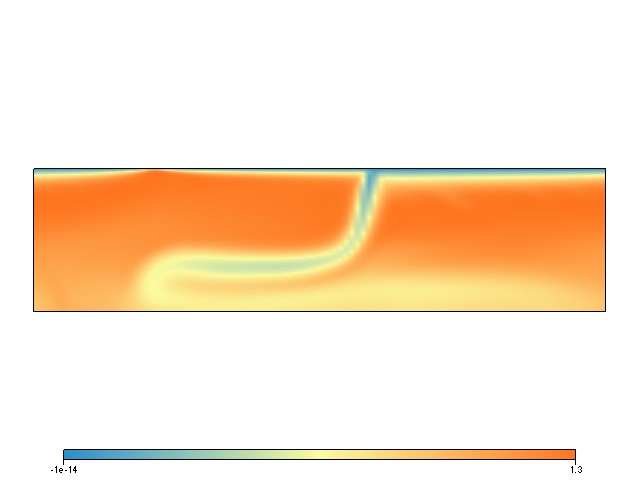

In [56]:
fig= glucifer.Figure()
fig.append( glucifer.objects.Surface(mesh, temperatureField))
#fig.append( glucifer.objects.Points(swarmPlateBoundary, pointSize=3))
#fig.show()
#fig.save_database('test.gldb')


Set up material parameters and functions
-----

Setup the viscosity to be a function of the temperature. Recall that these functions and values are preserved for the entire simulation time. 

In [ ]:
# The yeilding of the upper slab is dependent on the strain rate.
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))





In [ ]:
############
#Rheology
#############
#
#The final mantle rheology is composed as follows*:


omega = fn.misc.constant(1.)

if md.melt_viscosity_reduction:
    mvr =  fn.branching.conditional( [ (temperatureField > (ndp.Tmvp + 7.5*(1. - coordinate[1])) , 0.1 ),   (         True, 1.) ] )
    omega = omega*mvr


#implementation of the lower mantle viscosity increase, similar to Bello et al. 2015
a = 1.
B = 30.
d0 = 660e3/dp.LS  
ds = d0/10.
if md.lower_mantle:
    inner1 = 1. - 0.5*(1. - fn.math.tanh(((1. - d0)-(coordinate[1]))/(ds)))
    modfac = a*fn.math.exp(np.log(B)*inner1)
    omega = omega*modfac



#linearVisc = fn.math.exp(thetaT*(1. - temperatureField) + thetaZ*(depthFn))

enthalpyFn = ndp.E + depthFn*ndp.W #"activation enthalpy"
linearVisc = fn.misc.min(ndp.eta_max, omega*fn.math.exp(((enthalpyFn)/(temperatureField + ndp.TS)) 
                                                        - ((ndp.E )/(ndp.TIP + ndp.TS))))



ys =  ndp.cohesion + ndp.fcd*depthFn #tau_1 * 1e-5 is the cohesion value used in the paper

yielding = ys/(strainRate_2ndInvariant + 1e-15) #extra factor to account for underworld second invariant form


mantleviscosityFn0 = fn.misc.max(fn.misc.min(1./(((1./linearVisc) + (1./yielding))), ndp.eta_max), ndp.eta_min)


ridgeX = mesh.maxCoord[0] - (1./md.RES) #leave two elements to help decouple ridges.
mantleviscosityFn = fn.branching.conditional([(operator.and_(fn.math.abs(xFn) > ridgeX, depthFn < (1./md.RES)), 1.), 
                                    (True, mantleviscosityFn0)])

In [ ]:
figVisc= glucifer.Figure(figsize=(300*np.round(md.aspectRatio,2),300))
#figVisc.append( glucifer.objects.Points(swarm,linearVisc, pointSize=2,logScale=True, valueRange =[1e-3,1e5]))
figVisc.append( glucifer.objects.Points(swarm,mantleviscosityFn, pointSize=2,logScale=True))

#figVisc.append(glucifer.objects.VectorArrows(mesh, velocityField, scaling=0.0001))
#figVisc.show()

## Faults and fault rheology

In [ ]:
#####
#Faults 
#####
from marker2D import markerLine2D
#from unsupported.interfaces import markerLine2D


uw.barrier()

def update_swarm_from_faults(faults, proximityVariable, normalVectorVariable, signedDistanceVariable):
    """
    Compute fault attributes from the marker-line objects in the 'faults' list.
    Specifically:

      - proximityVariable carries information about which fault each swarm particle is close to (0 means none)
      - normalVectorVariable maps the orientation of the fault to nearby swarm particles
      - signedDistanceVariable carries the distance (positive means 'inside')  

      Unchecked error: if these variables are from different swarms 

    """

    for fault_seg in faults:

        swarm = proximityVariable.swarm

        f, nz = fault_seg.compute_marker_proximity(swarm.particleCoordinates.data)    
        proximityVariable.data[nz] = f[nz]

        dv, nzv = fault_seg.compute_normals(swarm.particleCoordinates.data)
        normalVectorVariable.data[nzv] = dv[nzv]

        sd, dnz = fault_seg.compute_signed_distance(swarm.particleCoordinates.data)
        signedDistanceVariable.data[dnz] = sd[dnz]

    return


def mask_materials(material, materialVariable, proximityVariable, normalVectorVariable, signedDistanceVariable):

    fptsMaskOut = np.where(materialVariable.data[:,0] != material)[0]

    normalVectorVariable.data[fptsMaskOut,:] = [0.0,0.0]
    proximityVariable.data[fptsMaskOut] = 0
    signedDistanceVariable.data[fptsMaskOut] = 0.0


def fault_strainrate_fns(fault_list, velocityField, faultNormalVariable, proximityproVariable):

    ## This is a quick / short cut way to find the resolved stress components.

    strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )



    ## "OPTIMIZED" VERSION

    _edotn_SFn = (        directorVector[0]**2 * strainRateFn[0]  + 
                    2.0 * directorVector[1]    * strainRateFn[2] * directorVector[0] + 
                          directorVector[1]**2 * strainRateFn[1]                          
                ) 

    # any non-zero proximity requires the computation of the above

    _edotn_SFn_Map    = { 0: 0.0 }
    for f in fault_list:
        _edotn_SFn_Map[f.ID] =  _edotn_SFn


    _edots_SFn = (  directorVector[0] *  directorVector[1] *(strainRateFn[1] - strainRateFn[0]) +
                    strainRateFn[2] * (directorVector[0]**2 - directorVector[1]**2)
                 )


    _edots_SFn_Map = { 0: 1.0e-15 }

    for f in fault_list:
        _edots_SFn_Map[f.ID] =  _edots_SFn


    edotn_SFn =     fn.branching.map( fn_key = proximityVariable, 
                                      mapping = _edotn_SFn_Map)


    edots_SFn =     fn.branching.map( fn_key = proximityVariable, 
                                      mapping = _edots_SFn_Map )


    return edotn_SFn, edots_SFn







In [ ]:

fthickness = (1./md.RES)

forientation = np.radians(ndp.orientation)
flength    = ndp.faultDepth/np.tan(forientation)
fstart = ndp.subzone - 2.*ndp.w0
faultLine1 = (fstart, 1.0)
faultLine2 = (faultLine1[0] - flength * np.cos(forientation), faultLine1[1]-flength*np.sin(forientation) )

faultLineXs = np.linspace(faultLine1[0], faultLine2[0], 50)
faultLineYs = np.linspace(faultLine1[1], faultLine2[1], 50)

faults = []

# Build a fault object out of this

fault_seg1  = markerLine2D(mesh, velocityField, faultLineXs, faultLineYs, fthickness, 0.0, 0.0, 1)
faults.append(fault_seg1)

In [ ]:
## Call the Fault helper functions 

proximityVariable.data[:] = 0

update_swarm_from_faults(faults, proximityVariable, directorVector, signedDistanceVariable)
#mask_materials(materialV, materialVariable, proximityVariable, directorVector, signedDistanceVariable)

# These should be general enough not to need updating when the faults move etc

edotn_SFn, edots_SFn = fault_strainrate_fns(faults, velocityField, directorVector, proximityVariable)

In [ ]:
fig= glucifer.Figure()
fig.append( glucifer.objects.Points(swarm, proximityVariable))
#fig.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling = 0.001))
#fig.show()
#fig.save_database('test.gldb')


In [ ]:
# This one maps to the fault-proximity variable 

# Delta Visc 


viscosityTI2_fn = fn.misc.min(mantleviscosityFn*0.999, fn.misc.max(0.0, mantleviscosityFn -  ndp.etaFault))

viscosityTIMap    = { 0: 0.0, 
                     1: viscosityTI2_fn
                   }

viscosityISOMap    = { 0: mantleviscosityFn, 
                     1: ndp.etaFault
                   }


isoViscosityFn  = fn.branching.map( fn_key  = proximityVariable, 
                                       mapping = viscosityISOMap )

secondViscosityFn  = fn.branching.map( fn_key  = proximityVariable, 
                                       mapping = viscosityTIMap )

System setup
-----

Since we are using a previously constructed temperature field, we will use a single Stokes solve to get consistent velocity and pressure fields.

**Setup a Stokes system**

In [ ]:
# Here we set a viscosity value of '1.' for both materials
#viscosityMapFn = fn.branching.map( fn_key = materialVariable,
#                         mapping = {lithosphereIndex:mantleviscosityFn, 
#                                    crustIndex:10.,
#                                    mantleIndex:mantleviscosityFn, 
#                                    eclIndex:mantleviscosityFn,
#                                    airIndex:ndp.Steta0} )

#densityMapFn = fn.branching.map( fn_key = materialVariable,
#                         mapping = {airIndex:ndp.StRA, 
#                                    lithosphereIndex:ndp.RA*temperatureField, 
#                                    crustIndex:ndp.RA*temperatureField, 
#                                    mantleIndex:ndp.RA*temperatureField} )

In [ ]:
# Construct our density function.
densityFn = ndp.RA * temperatureField

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
gravity = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * gravity

In [ ]:
#md.faultType = 'Iso'

In [ ]:
if md.faultType == 'Trans':
    stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=mantleviscosityFn,
                              _fn_viscosity2  = secondViscosityFn,
                              _fn_director    = directorVector, 
                              fn_bodyforce=buoyancyFn )

elif md.faultType == 'Iso':
    stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=isoViscosityFn,
                              fn_bodyforce=buoyancyFn )

else:
    stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=mantleviscosityFn, 
                              fn_bodyforce=buoyancyFn )
    

                              

**Set up and solve the Stokes system**

In [ ]:
solver = uw.systems.Solver(stokesPIC)

**Add the non-linear viscosity to the Stokes system**


solver.set_inner_method("mumps")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e6)
solver.options.scr.ksp_rtol = 1.0e-3
solver.solve(nonLinearIterate=True)
solver.print_stats()

In [ ]:
solver.set_inner_method("mumps")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
solver.options.scr.ksp_rtol = 1.0e-4
solver.solve(nonLinearIterate=True)
solver.print_stats()

solver.set_inner_method("mumps")
solver.set_penalty(1.0e6)
solver.options.scr.ksp_rtol = 1.0e-6


solver.solve( nonLinearIterate=True,  print_stats=False)
#solver.solve( nonLinearIterate=True, nonLinearTolerance=0.00001, print_stats=False)

#Set more advanced solver option
solver.options.main.Q22_pc_type='gkgdiag'
#solver.options.A11.ksp_rtol=1e-2
#solver.options.scr.ksp_rtol=1e-3
#solver.options.A11.ksp_type="cg"
solver.options.scr.use_previous_guess = True
#solver.options.scr.ksp_set_min_it_converge = 1
#solver.options.main.penalty=10.0

#solver.options.mg.levels = 3
#solver.options.main.remove_constant_pressure_null_space=True
#solver.options.main.penalty = 1e2

solver.options.A11.ksp_rtol=1e-4
solver.options.scr.ksp_rtol=1e-4

solver.options.A11.ksp_monitor=''
solver.options.A11.ksp_converged_reason=''
solver.solve( nonLinearIterate=True, nonLinearTolerance=0.00001, print_stats=False)

solver.set_inner_method("mg")
solver.set_penalty(1.0)
solver.solve( nonLinearIterate=True, nonLinearTolerance=0.00001, print_stats=False)
solver.print_stats()

**Create an advective diffusive system**

In [ ]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = ndp.H,
                                         fn_diffusivity = 1.0, 
                                         conditions     = [neumannTempBC, dirichTempBC] )

passiveadvector = uw.systems.SwarmAdvector( swarm         = swarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

In [ ]:
population_control = uw.swarm.PopulationControl(swarm,deleteThreshold=0.2, splitThreshold=1.,maxDeletions=3,maxSplits=0, aggressive=True, particlesPerCell=ppc)

In [ ]:
###################
#Volume Restriction functions
###################

#Level 1. Global
globRestFn = fn.misc.constant(1.)


#Level 2. lithosphere - mantle:
tempMM = fn.view.min_max(temperatureField)
tempMM.evaluate(mesh)
TMAX = tempMM.max_global()
mantleconditions = [ (                                  temperatureField < 0.9*TMAX, 1.),
                   (                                                   True , 0.) ]
lithRestFn = fn.branching.conditional(mantleconditions)
lithRestFn*=globRestFn #Add next level up in heirarchy


In [ ]:
###################
#Surface Restriction functions
###################

def platenessFn(val = 0.1):
    normgradV = fn.math.abs(velocityField.fn_gradient[0]/fn.math.sqrt(velocityField[0]*velocityField[0])) #[du*/dx]/sqrt(u*u)



    srconditions = [ (                                  normgradV < val, 1.),
                   (                                                   True , 0.) ]


    return fn.branching.conditional(srconditions)

srRestFn = platenessFn(val = 0.1)

In [ ]:
###################
#Setup any Functions to be integrated
###################

sqrtv2 = fn.math.sqrt(fn.math.dot(velocityField,velocityField))
vx = velocityField[0]
v2x = fn.math.dot(velocityField[0],velocityField[0])
sqrtv2x = fn.math.sqrt(fn.math.dot(velocityField[0],velocityField[0]))
dw = temperatureField*velocityField[1]
sinner = fn.math.dot( strainRate_2ndInvariant, strainRate_2ndInvariant )
vd = 2.*mantleviscosityFn*sinner
dTdZ = temperatureField.fn_gradient[1]


In [ ]:
###################
#Create integral, max/min templates 
###################

def volumeint(Fn = 1., rFn=globRestFn):
    return uw.utils.Integral( Fn*rFn,  mesh )

def surfint(Fn = 1., rFn=globRestFn, surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"]):
    return uw.utils.Integral( Fn*rFn, mesh=mesh, integrationType='Surface', surfaceIndexSet=surfaceIndexSet)

def maxMin(Fn = 1.):
    #maxMin(Fn = 1., rFn=globRestFn
    #vuFn = fn.view.min_max(Fn*rFn) #the restriction functions don't work with the view.min_max fn yet
    vuFn = fn.view.min_max(Fn)
    return vuFn

In [ ]:
#Setup volume integrals on different sub regions

##Whole rock domain

_areaintRock = volumeint(globRestFn)
_tempintRock = volumeint(temperatureField, globRestFn)
_rmsintRock = volumeint(sqrtv2, globRestFn)
_dwintRock = volumeint(dw, globRestFn)
_vdintRock = volumeint(vd, globRestFn)

##Lith 

_areaintLith  = volumeint(lithRestFn)
_tempintLith  = volumeint(temperatureField, lithRestFn)
_rmsintLith  = volumeint(sqrtv2,lithRestFn)
_dwintLith  = volumeint(dw,lithRestFn)
_vdintLith  = volumeint(vd,lithRestFn)

In [ ]:
#Setup surface integrals

_surfLength = surfint()
_rmsSurf = surfint(v2x)
_nuTop = surfint(dTdZ)
_nuBottom = surfint(dTdZ, surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])
_plateness = surfint(srRestFn)

In [ ]:
_maxMinVel = maxMin(velocityField) 
dummyFn = _maxMinVel.evaluate(mesh)

_maxMinSr = maxMin(strainRate_2ndInvariant) 
dummyFn = _maxMinSr.evaluate(mesh)


#Surface extrema
_maxMinVxSurf = maxMin(vx)
dummyFn = _maxMinVxSurf.evaluate(tWalls)

In [ ]:
#Volume Ints
areaintRock = _areaintRock.evaluate()[0]
tempintRock = _tempintRock.evaluate()[0]
rmsintRock = _rmsintRock.evaluate()[0]
dwintRock = _dwintRock.evaluate()[0]
vdintRock = _vdintRock.evaluate()[0]
areaintLith = _areaintLith.evaluate()[0]
tempintLith = _tempintLith.evaluate()[0]
rmsintLith = _rmsintLith.evaluate()[0]
dwintLith = _dwintLith.evaluate()[0]
vdintLith = _vdintLith.evaluate()[0]


#Surface Ints
surfLength = _surfLength.evaluate()[0]
rmsSurf = _rmsSurf.evaluate()[0]
nuTop = _nuTop.evaluate()[0]
nuBottom = _nuBottom.evaluate()[0]
plateness = _plateness.evaluate()[0]

#Max mins
maxVel = _maxMinVel.max_global()
minVel = _maxMinVel.min_global() 
maxSr = _maxMinSr.max_global()
minSr = _maxMinSr.min_global()
maxVxsurf = _maxMinVxSurf.max_global()
minVxsurf = _maxMinVxSurf.min_global()

In [ ]:
print(areaintRock)
print(tempintRock)
print(rmsintRock)
print(dwintRock)
print(vdintRock)
print(areaintLith)
print(tempintLith )
print(rmsintLith)
print(dwintLith)
print(vdintLith)

print(surfLength)
print(rmsSurf)
print(nuTop)
print(nuBottom)
print(plateness)


print(maxVel)
print(minVel)
print(maxSr)
print(minSr)
print(maxVxsurf)
print(minVxsurf)

Viz.
-----

In [ ]:
if figures == 'store':
    fullpath = os.path.join(outputPath + "gldbs/")
    store = glucifer.Store(fullpath + 'subduction.gldb')

    figTemp = glucifer.Figure(store,figsize=(300*np.round(md.aspectRatio,2),300))
    figTemp.append( glucifer.objects.Points(swarm,temperatureField))

    figVisc= glucifer.Figure(store, figsize=(300*np.round(md.aspectRatio,2),300))
    figVisc.append( glucifer.objects.Points(swarm,mantleviscosityFn, logScale=True, valueRange =[1e-3,1e5]))
    
    figSr= glucifer.Figure(store, figsize=(300*np.round(md.aspectRatio,2),300))
    figSr.append( glucifer.objects.Points(swarm,strainRate_2ndInvariant, logScale=True))
    figSr.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.0005))
    
if figures == 'gldb':
    #Pack some stuff into a database as well
    figDb = glucifer.Figure()
    #figDb.append( glucifer.objects.Mesh(mesh))
    figDb.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.0005))
    #figDb.append( glucifer.objects.Points(swarm,tracerVariable, colours= 'white black'))
    #figDb.append( glucifer.objects.Points(swarm,materialVariable))
    #figDb.append( glucifer.objects.Points(swarm,viscMinVariable))
    #figDb.append( glucifer.objects.Points(swarm,fnViscMin))
    figDb.append( glucifer.objects.Points(swarm, mantleviscosityFn, logScale=True))
    #figDb.append( glucifer.objects.Points(swarm, strainRate_2ndInvariant, logScale=True))
    figDb.append( glucifer.objects.Points(swarm,temperatureField))

#### Miscellania


In [ ]:
##############
#Create a numpy array at the surface to get surface information on (using parallel-friendly evaluate_global)
##############

surface_xs = np.linspace(mesh.minCoord[0], mesh.maxCoord[0], mesh.elementRes[0] + 1)
surface_nodes = np.array(zip(surface_xs, np.ones(len(surface_xs)*mesh.maxCoord[1]))) #For evaluation surface velocity
normgradV = velocityField.fn_gradient[0]/fn.math.sqrt(velocityField[0]*velocityField[0])

tempMM = fn.view.min_max(temperatureField)
dummy = tempMM.evaluate(mesh)

In [ ]:
##############
#Simple function to return info about location of plate boundaries
##############

def getnearpos(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx 

def plate_info(srfilename, minx, maxx,  searchdx, oldszloc = 0.0):
    """
    Use the surface strain rate field to find the location of the subduction zone in 2d
    
    """
    if type(srfilename) == str: #read surface strain rate points from file
        sr = np.load(srfilename)
    else:
        sr =  srfilename        #read surface strain rates directly from array
    xs = np.linspace(minx,maxx,sr.shape[0] )
    #infs at the ends of the SR data...replace with adjacent values
    sr[0] = sr[1] 
    sr[-1] = sr[2]
    #Normalize
    srx = (sr- sr.mean()) /(sr.max() - sr.min())
    #reduce the search domain, to near the previous PB location
    lx, rx = getnearpos(xs, oldszloc - searchdx),  getnearpos(xs, oldszloc + searchdx)
    red_xs, red_sr = xs[lx:rx], srx[lx:rx]
    #return the minima
    newszLoc = red_xs[np.argmin(red_sr)]
    return newszLoc 

In [ ]:
##############
#These functions handle checkpointing
##############


#Subzone = ndp.subzone


def checkpoint1(step, checkpointPath,filename, filewrites):
    path = checkpointPath + str(step) 
    os.mkdir(path)
    ##Write and save the file, if not already a writing step
    if not step % filewrites == 0:
        f_o.write((16*'%-15s ' + '\n') % (areaintRock, tempintRock, rmsintRock, dwintRock, vdintRock,
                                  areaintLith, tempintLith,rmsintLith, dwintLith, vdintLith,
                                  rmsSurf, nuTop, nuBottom, plateness, ndp.subzone, realtime))
    filename.close()
    shutil.copyfile(os.path.join(outputPath, outputFile), os.path.join(path, outputFile))


def checkpoint2(step, checkpointPath, swarm, filename, varlist = [], varnames = []):
    path = checkpointPath + str(step) 
    velfile = "velocityField" + ".hdf5"
    tempfile = "temperatureField" + ".hdf5"
    pressfile = "pressureField" + ".hdf5"
    velocityField.save(os.path.join(path, velfile))
    temperatureField.save(os.path.join(path, tempfile))
    pressureField.save(os.path.join(path, pressfile))
    swarm.save(os.path.join(path, "swarm.h5") ) 
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.save(os.path.join(path,varnames[ix] + ".h5"))
    
    #Save the parameters
    dict_list = [dp, sf, ndp, md] #if any of the dictionaries have changed, this list needs to be rebuilt
    save_pickles(dict_list, dict_names, path)
    
#Simple Checkpoint function for the faults / interfaces (markerLine2D)
def checkpoint3(step,  checkpointPath, interfaces,interfacenames ):
    path = checkpointPath + str(step)
    for ix in range(len(interfaces)):
        intf = interfaces[ix]
        intf.swarm.save(os.path.join(path,interfacenames[ix] + ".h5"))
    

In [ ]:
tempMM.max_global(), temperatureField.data.max()

Main simulation loop
-----


In [ ]:
# initialise timer for computation
start = time.clock()

In [ ]:
#while step < 21:
while realtime < 1.:

    # solve Stokes and advection systems
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()*md.courantFac
    if step == 0:
        dt = 0.
    advDiff.integrate(dt)
    #passiveadvector.integrate(dt)
    #for f in interfaces:
    #    f.advection(dt)
    

    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    
    ################
    #Update temperature field in the air region
    #Do this better...
    ################
    if (step % sticky_air_temp == 0):
        for index, coord in enumerate(mesh.data):
            if coord[1] >= 1.:
                temperatureField.data[index] = ndp.TSP
                
                
    ################
    # Calculate the Metrics
    ################
    if (step % metric_output == 0):
        
        ###############
        #Metrics
        ###############
        areaintRock = _areaintRock.evaluate()[0] #trivial except when using sticky air
        tempintRock = _tempintRock.evaluate()[0]
        rmsintRock = _rmsintRock.evaluate()[0]
        dwintRock = _dwintRock.evaluate()[0]
        vdintRock = _vdintRock.evaluate()[0]
        areaintLith = _areaintLith.evaluate()[0]
        tempintLith = _tempintLith.evaluate()[0]
        rmsintLith = _rmsintLith.evaluate()[0]
        dwintLith = _dwintLith.evaluate()[0]
        vdintLith = _vdintLith.evaluate()[0]
    
        #Surface integrals
        rmsSurf = _rmsSurf.evaluate()[0]
        nuTop = _nuTop.evaluate()[0]
        nuBottom = _nuBottom.evaluate()[0]
        plateness = _plateness.evaluate()[0]
        #extrema
        maxVel = _maxMinVel.max_global()
        minVel = _maxMinVel.min_global() 
        maxSr = _maxMinSr.max_global()
        minSr = _maxMinSr.min_global()
        maxVxsurf = _maxMinVxSurf.max_global()
        minVxsurf = _maxMinVxSurf.min_global()
        # output to summary text file
        if uw.rank()==0:
            f_o.write((16*'%-15s ' + '\n') % (areaintRock, tempintRock, rmsintRock, dwintRock, vdintRock,
                                  areaintLith, tempintLith,rmsintLith, dwintLith, vdintLith,
                                  rmsSurf, nuTop, nuBottom, plateness, ndp.subzone, realtime))

    ################
    #Also repopulate entire swarm periodically
    ################
    #if step % swarm_repop == 0:
    #population_control.repopulate()   
    ################
    #Gldb output
    ################ 
    if (step % gldbs_output == 0): 
        if figures == 'gldb':
            #Remember to rebuild any necessary swarm variables
            fnamedb = "dbFig" + "_" + str(step) + ".gldb"
            fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
            figDb.save_database(fullpath)
            
            #Temp figure
            #fnamedb = "restrictFig" + "_" + str(step) + ".gldb"
            #fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
            #figRestrict.save_database(fullpath)
        elif figures == 'store':      
            fullpath = os.path.join(outputPath + "gldbs/")
            store.step = step
            #Save figures to store
            figVisc.save( fullpath + "Visc" + str(step).zfill(4))
            #figMech.save( fullPath + "Mech" + str(step).zfill(4))
            figTemp.save( fullpath + "Temp"    + str(step).zfill(4))
            figSr.save( fullpath + "Str_rte"    + str(step).zfill(4))
            
    ################
    #Files output
    ################ 
    if (step % files_output == 0):

        vel_surface = velocityField.evaluate_global(surface_nodes)
        norm_surface_sr = normgradV.evaluate_global(surface_nodes)
        if uw.rank() == 0:
            fnametemp = "velsurface" + "_" + str(step)
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            np.save(fullpath, vel_surface)
            fnametemp = "norm_surface_sr" + "_" + str(step)
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            np.save(fullpath, norm_surface_sr)
            
    ################
    #Update the subduction zone / plate information
    ################ 
    
    comm.barrier()
    if (step % files_output == 0):
        
        if uw.rank() == 0:
            fnametemp = "norm_surface_sr" + "_" + str(step) + ".npy"
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            ndp.subzone = plate_info(fullpath, MINX, MAXX,  800e3/dp.LS, oldszloc = ndp.subzone)
            
    
    
    
    ################
    #Checkpoint
    ################
    if step % checkpoint_every == 0:
        if uw.rank() == 0:
            checkpoint1(step, checkpointPath,f_o, metric_output)           
        checkpoint2(step, checkpointPath, swarm, f_o, varlist = varlist, varnames = varnames)
        #checkpoint3(step,  checkpointPath, interfaces,interfacenames )
        f_o = open(os.path.join(outputPath, outputFile), 'a') #is this line supposed to be here?    
    
    
    
    
f_o.close()
print 'step =',step

In [ ]:
xvelMean = uw.utils.Integral(velocityField[0],  mesh )
xvelMean.evaluate()

In [ ]:
velocityField[0].evaluate(iWalls).max()

In [ ]:
figVisc= glucifer.Figure(figsize=(300*np.round(md.aspectRatio,2),300))
#figVisc.append( glucifer.objects.Points(swarm,linearVisc, pointSize=2,logScale=True, valueRange =[1e-3,1e5]))
figVisc.append( glucifer.objects.Points(swarm,linearVisc, pointSize=2,logScale=True))

figVisc.append(glucifer.objects.VectorArrows(mesh, velocityField, scaling=0.001))
figVisc.show()

In [ ]:
velocityField[0].evaluate(iWalls)